In [43]:
### Lectures des donnees et fonctions
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)    # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs(m - m.hat), na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2, m)
    }

In [44]:
# merge users and ratings
# traitement des donnes preliminaires
names(u.user)<- c('user.id','age','gender','job')
u.user <- u.user[,c(-5)]
# changement de l age en categorie
cat.age <- function(x) floor(x/20)
u.user[, 2] <- sapply(u.user[, 2], cat.age)
for (i in 2:4){
u.user[, i] <- sapply(u.user[, i], as.factor)
}
names(u.data)<- c('user.id','movie.id','rating')
u.data <- u.data[,c(-4)]
u.data[, 3] <- sapply(u.data[, 3], as.factor)
u.item <- u.item[,c(-2,-3,-4,-5)]
for (i in 2:20){
u.item[, i] <- sapply(u.item[, i], as.factor)
}
u.r <- merge(u.user, u.data, by = "user.id")
# merge userRating with movie to have actual movie titles instead of ids
u.r.v <- merge(u.r, u.item, by = "movie.id")
head(u.r.v)

movie.id,user.id,age,gender,job,rating,unknown,Action,Adventure,Animation,...,Fantasy,Film.Noir,Horror,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western
1,918,2,M,scientist,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,684,1,M,student,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,660,1,M,student,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,339,1,M,lawyer,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,699,2,M,other,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,94,1,M,student,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# chargement de la librairie
library('e1071')

In [12]:
# creation de la formule pour 
formula <- as.factor(rating) ~ .

In [11]:
# fonction de reduction de dimensions et calcul de MAE
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.c], m.na[i.test.c])
    }
to.plot <- c()
cv.b <- c()

In [ ]:
# creation du 5-fold
i.observed <- dim(u.r.v)[1]
set.seed(1)
i.hasard <- sample(seq(1,i.observed,1), i.observed)
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, dim(u.r.v)[1])
for (i in 1:5){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
    

## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
u.r.v.train <- u.r.v[i.train.b,]
u.r.v.test <- u.r.v[i.test.b,]
nb <- naiveBayes(formula, data = u.r.v.train)
new.m <- m
# creation des indexs de la matrice m
i.test.c <- rep(FALSE,943*1682)
for (j in seq_len(fold.size)){
    new.m[u.r.v.test[j,2],u.r.v.test[j,1]]<-0
    i.test.c[943*(u.r.v.test[j,1]-1)+u.r.v.test[j,2]]<-TRUE
}
    
    
# imputation des données pour la matrice
for (k in seq_len(943)){
    for (l in seq_len(1682)){
        if (new.m[k,l]==0){
            new.m[k,l]<- predict(nb, newdata = cbind(u.item[l,],u.user[k,])) 
        }
    }
}
    
# sauvegarde des données pour utilisation futur
write.table(new.m,file=paste("out/bayes/nb", toString(i), ".csv", sep = "")) # drops the rownames
write.table(i.test.c,file=paste("out/bayes/nbTestc", toString(i), ".csv", sep = "")) # drops the rownames
write.table(i.test.b,file=paste("out/bayes/nbTestb", toString(i), ".csv", sep = "")) # drops the rownames
m.train <- new.m
m.train <- m.train
m.svd <- svd(m.train)
# calcul du MAE et du MAE par dimensions
cv.b <- c(cv.b,mae(m.train[i.test.c],m.na[i.test.c]))
to.plot<-rbind(to.plot,unlist(lapply(seq(50), new.m.cv)))
    }


chargement des données calculées précedemment

In [45]:
table = list()
test = list()

In [46]:
table[[1]] <- read.table(file=paste("out/bayes/nb1.csv", sep = "")) # drops the rownames
table[[2]] <- read.table(file=paste("out/bayes/nb2.csv", sep = "")) # drops the rownames
table[[3]] <- read.table(file=paste("out/bayes/nb3.csv", sep = "")) # drops the rownames
table[[4]] <- read.table(file=paste("out/bayes/nb4.csv", sep = "")) # drops the rownames
table[[5]] <- read.table(file=paste("out/bayes/nb5.csv", sep = "")) # drops the rownames

test[[1]] <- read.table(file=paste("out/bayes/nbTestc1.csv", sep = "")) # drops the rownames
test[[2]] <- read.table(file=paste("out/bayes/nbTestc2.csv", sep = "")) # drops the rownames
test[[3]] <- read.table(file=paste("out/bayes/nbTestc3.csv", sep = "")) # drops the rownames
test[[4]] <- read.table(file=paste("out/bayes/nbTestc4.csv", sep = "")) # drops the rownames
test[[5]] <- read.table(file=paste("out/bayes/nbTestc5.csv", sep = "")) # drops the rownames


calcul du MAE et du MAE par dimensions

In [ ]:
to.plot<-c()
cv.b <- c()
for (i in 1:5){
m.train <- data.matrix(table[[i]])
i.test.c <- unlist(test[[i]])
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(40), new.m.cv)))
cv.b <- c(cv.b,mae(m.train[i.test.c],m.na[i.test.c]))
    }
to.plot<-apply(to.plot,2,unlist)

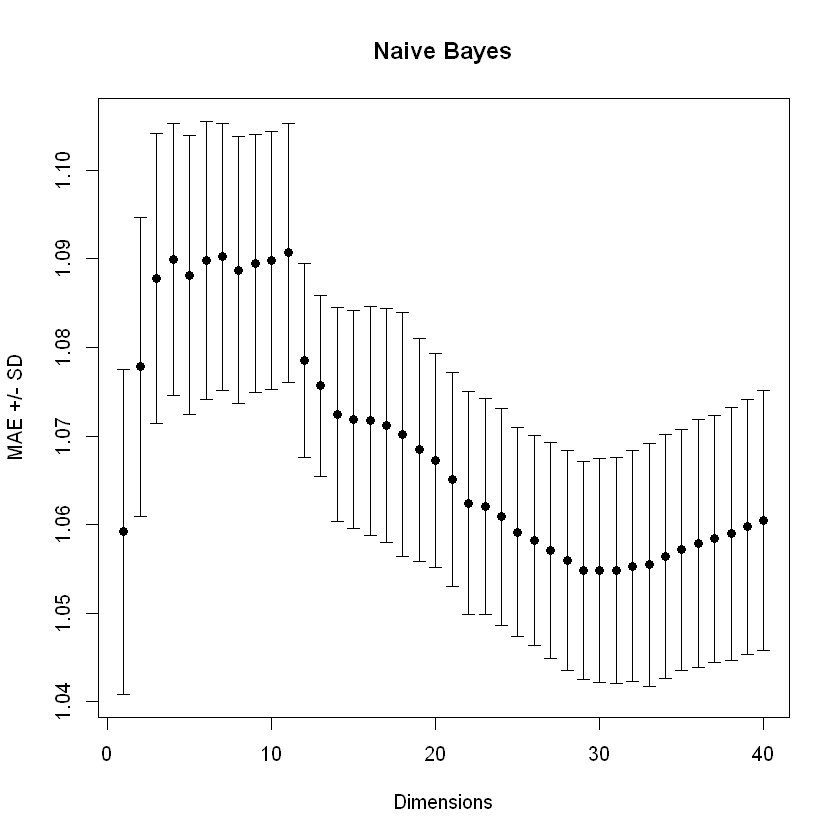

In [40]:
# creation de la figure
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Dimensions", ylab="MAE +/- SD",
    main="Naive Bayes"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

Moyenne du MAE par dimension pour les 5fold

In [41]:
avg

[1] 1.059162 1.077809 1.087784 1.089941 1.088176 1.089850 1.090236 1.088743
 [9] 1.089509 1.089871 1.090686 1.078537 1.075699 1.072465 1.071869 1.071721
[17] 1.071203 1.070156 1.068450 1.067218 1.065137 1.062418 1.062038 1.060861
[25] 1.059159 1.058183 1.057119 1.055959 1.054825 1.054811 1.054794 1.055317
[33] 1.055451 1.056421 1.057160 1.057886 1.058420 1.058955 1.059744 1.060437

Moyenne du MAE pour les 5fold

In [42]:
mean(cv.b)

[1] 1.18089

On ecrit la valeur dans un fichier pour utilisation future

In [38]:
write.table(avg, file="out/total/bayes.csv")